## Introduction

### Context
I aim to analyze the results from the [xkcd Color Survey](https://github.com/rfordatascience/tidytuesday/blob/main/data/2025/2025-07-08/readme.md).
The survey was taken in 2010, got hundreds of thousands of responses, and asked respondents to name colors they saw with the goal of
"revealing the different ways in which people perceive and label colors".

### Question to answer
* Is there any significant difference between groups in their categorization of colors?
* If so, can the groups be found and labelled?
* Who is the most and least accurate?
* Are certain groups more likely to more specific in the names they give colors?
* Which colors are mentioned most?

### Data
There are three tables in the dataset. The variables we are given are:

* Answers table (answers.csv):\
  `user_id`: ID of the user who gave the answer\
  `hex`: Hex color code shown to the user\
  `rank`: "Rank of the color" that the user gave as an answer (i.e. a foreign key into the "color_ranks" table).

* Colors (color_ranks.csv):\
  `color`: The name of the color\
  `rank`: Rank of the color\
  `hex`: Hex code of the color

* Users (users.csv):\
  `user_id`: Self explanatory\
  `monitor`: User's monitor type\
  `y_chromosome`: Whether the user reported as having a y chromosome or not.\
  `colorblind`: Whether the user reported as being colorblind or not.\
  `spam_prob`: Probability of user being a spam user (0-1).


## Getting the data from github
The code is hosted on GitHub. Luckily, the data was also [cleaned for us already](https://github.com/nrennie/xkcd-color-survey/). 

In [1]:
# We need these libraries
import math
import pandas as pd
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth

from typing import TypeAlias

In [2]:
# Get data
answers = pd.read_csv("https://raw.githubusercontent.com/nrennie/xkcd-color-survey/main/data/clean/answers.csv")
color_ranks = pd.read_csv("https://raw.githubusercontent.com/nrennie/xkcd-color-survey/main/data/clean/color_ranks.csv")
users = pd.read_csv("https://raw.githubusercontent.com/nrennie/xkcd-color-survey/main/data/clean/users.csv")

# Clean data
color_ranks = color_ranks.set_index('rank')
users = users.set_index('user_id').astype({'y_chromosome': 'bool',
                                           'colorblind': 'bool'})

### Defining colors:
The data uses hex values. To do operations on the data, it's convenient to first convert it to rgb:

In [3]:
# Color function definitions
RGBType: TypeAlias = npt.NDArray[np.uint8]

def hex_to_rgb(value: str) -> RGBType:
    """ Convert hex to numpy array [r, g, b] """
    value = value.strip('# \r\t\n') # Remove all whitespace and "#"

    if len(value) != 6:
        raise ValueError(f'Malformed hex code: {value}. Must be 6 characters!')

    return np.array(tuple(int(value[i:i+2], 16) for i in (0, 2, 4)), dtype = np.uint8)

def rgb_to_hex(rgb: RGBType) -> str:
    """ Convert numpy array [r, g, b] to hex """
    arr = np.asarray(rgb, dtype = np.uint8).ravel()
    r, g, b = arr[0], arr[1], arr[2]
    string = f'#{r:02X}{g:02X}{b:02X}'
    return string.upper()


# Averaging colors
In our survey, respondents were shown a random color and asked to name it. If we choose purple as an example, then there's a range of thousands of hex codes that were deemed "purple". What if we want to know what the average is, to find the most purple purple? Finding the average of colors is actually more complicated than it sounds. For our purposes, we'll try to model a human's perception of color^[Of course, this depends on the human and the eyes. Generally we'll refer to common scientific standards that attempt to measure how *most* people *usually* perceive colors].

A naive approach is to simply find the arithmetic mean for the R, G, and B values individually of the colors. For example, let's try it with these two colors: `#E223F7` and `#35CEFC`. Converting the hex values into RGB, we get (226, 35, 247) and (53, 206, 252). Averaging element-wise, the result is (140, 120, 250) or `#8C78FA`. You can see these colors below:

In [4]:
def simple_arithmetic_mean(hex_1: str, hex_2: str) -> str:
    """Average two colors by using the element-wise arithmetic mean of the RGB values."""
    rgb_1 = hex_to_rgb(hex_1).astype(np.float64)
    rgb_2 = hex_to_rgb(hex_2).astype(np.float64)

    avg = (rgb_1 + rgb_2) / 2
    avg = np.rint(avg).astype(np.uint8) # Rounds to nearest even number

    return rgb_to_hex(avg)

color_a, color_b = "#E223F7", "#35CEFC"
color_c = simple_arithmetic_mean(color_a, color_b)

print(f'Arithmetic mean of {color_a} and {color_b} = {color_c}')


Arithmetic mean of #E223F7 and #35CEFC = #8C78FA


![Color average by arithmetic mean](../img/color_mean_arithmetic_method.svg)

Depending on the device and screen you're reading this on, you'll notice that the result looks darker than either input color. This is because our eyes don't see brightness linearly. You can gain an intuition for this by turning on two flashlights in a dark room: it's probably pretty easy to tell the difference between when both are on or when only one is. If you imagine 100 flashlights in the same room, you're unlikely to see a difference between 99 and 100.

## Gamma correction

To account for this, the sRGB color space uses gamma correction to try to imitate how our eyes actually see. We can approximate gamma correction (we'll talk about the actual formula later) by using the square root. That is, the RGB values are the square root of the "actual" values. It's easy to see now why the previous approach tended darker: since we were actually averaging the square roots, and the mean of square roots is less than the square root of a mean (except at 0). More formally:

$\frac{\sqrt{x_1}+\sqrt{x_2}}{2} \leqslant \sqrt{\frac{x_1+x_2}{2}}$, for all $x_1, x_2 \in \mathbb{R}_{\geq 0}$.

So, we can get a better result by first squaring, averaging those values, and then square rooting, like so:

$\overline{X} = \sqrt{\frac{x_1^2 + x_2^2}{2}}$

In [5]:
def simple_quadratic_mean(hex_1: str, hex_2: str) -> str:
    """Average two colors by using the element-wise quadratic mean of the RGB values."""
    rgb_1 = hex_to_rgb(hex_1).astype(np.float64)
    rgb_2 = hex_to_rgb(hex_2).astype(np.float64)

    avg = np.sqrt((np.square(rgb_1) + np.square(rgb_2)) / 2)
    avg = np.rint(avg).astype(np.uint8) # Rounds to nearest even number

    return rgb_to_hex(avg)

color_a, color_b = "#E223F7", "#35CEFC"
color_c = simple_quadratic_mean(color_a, color_b)

print(f'Quadratic mean of {color_a} and {color_b} = {color_c}')

Quadratic mean of #E223F7 and #35CEFC = #A494FA


Which gives us a new average of (164, 148, 250), or `#A494FA`

![Color average through quadratic mean](../img/color_mean_quadratic_method.svg)

This results in a color that looks much closer to what we might imagine the average of the colors to look like. But, we can make it even better.

## Making it even better
So far we've been approximating the sRGB gamma function as a square root, but the actual formula is a bit more complicated. Using the IEC2003 specification, the formulas are as follows (where $X$ is the value *without* gamma and $X'$ is the value *with*):

$X'=
\begin{cases}
    12.92X, & X \leqslant 0.0031308\\
    1.055\sqrt[2.4]{X} - 0.055, & \text{otherwise}
\end{cases}$

$X=
\begin{cases}
    X'/12.92, & X' \leqslant 0.04045\\
    (\frac{X'+0.055}{1.055})^{2.4}, & \text{otherwise}
\end{cases}$

It's important to note that here the values range from 0 to 1, instead of 0-255 like we've been using.


In [6]:
def rgb_add_gamma(rgb: RGBType) -> RGBType:
    """Convert linear RGB into sRGB with the gamma function"""
    rgb = rgb.astype(np.float64) / 255 # Convert from 0-255 to 0-1

    x = np.where(rgb <= 0.0031308,
                 12.92 * rgb,
                 1.055 * (rgb ** (1.0/2.4)) - 0.055)

    x = np.rint(x * 255) # Covert back to 0-255
    x = np.clip(x, 0, 255) # Just in case there were any floating point shenanigans

    return x.astype(np.uint8)

def rgb_remove_gamma(rgb: RGBType) -> RGBType:
    """Convert gamma-encoded sRGB into linear RGB"""
    rgb = rgb.astype(np.float64) / 255 # Convert from 0-255 to 0-1

    x = np.where(rgb <= 0.04045,
                 rgb / 12.92,
                 ((rgb + 0.055) / 1.055) ** 2.4)

    x = np.rint(x * 255) # Covert back to 0-255
    x = np.clip(x, 0, 255) # Floating on my point 'til I number

    return x.astype(np.uint8)

def gamma_aware_mean(hex_1: str, hex_2: str) -> str:
    rgb_1 = hex_to_rgb(hex_1)
    rgb_2 = hex_to_rgb(hex_2)

    # To linear rgb
    lin_1 = rgb_remove_gamma(rgb_1).astype(np.float64)
    lin_2 = rgb_remove_gamma(rgb_2).astype(np.float64)

    # Arithmetic mean of gamma-removed values
    avg = (lin_1 + lin_2) / 2.0
    avg = np.rint(avg).astype(np.uint8) # Rounds to nearest even number

    # Add gamma back:
    avg = rgb_add_gamma(avg)

    return rgb_to_hex(avg)

color_a, color_b = "#E223F7", "#35CEFC"
color_c = gamma_aware_mean(color_a, color_b)

print(f'Gamma-aware mean of {color_a} and {color_b} = {color_c}')


Gamma-aware mean of #E223F7 and #35CEFC = #AA98F9


By removing the gamma, taking the arithmetic mean of those values, and then adding back the gamma, we get a slightly better average (though the difference may be subtle depending on the screen and environment):

![Color average through gamma-aware mean](../img/color_mean_gamma_aware_method.svg)

There are still flaws with this method. Even with our gamma-aware method, sRGB doesn't perfectly match perceived lightness across colors with varied hue and constant saturation.
In other words, if you have a red color and a purple color with the same saturation, the red will still appear darker because human eyes don't treat the brightness of all colors the same.
In order to get as close to a perfect average as possible, what we really need is a "perceptually-uniform" color space.

## A perceptually uniform color space
Oklab^[So-called because it's an "OK" Lab color space] is a relatively new color space that aims to be relatively perceptually uniform. If you want to know how it was derived, see [Björn Ottosson's article](https://bottosson.github.io/posts/oklab/) where he introduces Oklab.

Instead of RGB, Oklab uses `L` (lightness), `a` (green/red scale), and `b` (blue/yellow scale). Obviously, if we average two colors with the same lightness the result will vary only in hue, which is what we want. To convert our hex codes to this color space, we need to do conduct a middle step from sRGB -> CIE XYZ -> Oklab. CIE XYZ is yet another color space, but we can safely ignore the specifics. All we really need to know are that *it's* 3 coordinates are $l$, $m$, and $s$. The formula to go from sRGB -> CIE XYZ is given by:

$\begin{bmatrix} l\\m\\s \end{bmatrix}=
M_1
\begin{bmatrix} R_\text{linear} \\ G_\text{linear} \\ B_\text{linear} \end{bmatrix}$

(Note that we use the linear RGB values here.) Then, to go from CIE XYZ to Oklab:

$\begin{bmatrix} l'\\m'\\s' \end{bmatrix}=
\begin{bmatrix}
\sqrt[3]{l} \\ \sqrt[3]{m} \\ \sqrt[3]{s}
\end{bmatrix}$

$\begin{bmatrix} L \\ a \\ b \end{bmatrix}=
M_2
\begin{bmatrix} l'\\m'\\s' \end{bmatrix}$

Where:

$M_1 =
\begin{bmatrix}
0.4122214708 & 0.5363325363 & 0.0514459929 \\
0.2119034982 & 0.6806995451 & 0.1073969566 \\
0.0883024619 & 0.2817188376 & 0.6299787005
\end{bmatrix} \\ \text{, and }
M_2 =
\begin{bmatrix}
+0.2104542553 & +0.7936177850 & -0.0040720468 \\
+1.9779984951 & -2.4285922050 & +0.4505937099 \\
+0.0259040371 & +0.7827717662 & -0.8086757660
\end{bmatrix}$

To go backwards, we simply have to do the steps in reverse order with the inverse of the given matrices:

$\begin{bmatrix} l'\\ m'\\ s'\\ \end{bmatrix}=
M_2^{-1}\begin{bmatrix} L \\ a \\ b \end{bmatrix}$

$\begin{bmatrix} l\\ m\\ s\\ \end{bmatrix}=
\begin{bmatrix} l'^3\\ m'^3\\ s'^3\\ \end{bmatrix}$

$\begin{bmatrix} R_\text{linear} \\ G_\text{linear} \\ B_\text{linear} \end{bmatrix}=
M_1^-1
\begin{bmatrix} l\\ m\\ s\\ \end{bmatrix}$

So, the new order of operations is:
- Remove sRGB gamma
- Squash to range 0-1 (divide by 255)
- Convert to CIE XYZ
- Convert to Oklab
- Average colors (arithmetic mean)
- Convert back to CIE XYZ
- Convert back to RGB
- Expand to range 0-255
- Re-add sRGB gamma

In [7]:
LabType: TypeAlias = npt.NDArray[np.float64]

def rgb_to_oklab(rgb: RGBType) -> LabType:
    rgb = rgb_remove_gamma(rgb).astype(np.float64) / 255 # Remove gamma
    rgb = rgb[..., None] # Convert to a column vector

    m_1 = np.array([[0.4122214708, 0.5363325363, 0.0514459929],
                    [0.2119034982, 0.6806995451, 0.1073969566],
                    [0.0883024619, 0.2817188376, 0.6299787005]])

    m_2 = np.array([[0.2104542553, 0.7936177850, -0.0040720468],
                     [1.9779984951, -2.4285922050, 0.4505937099],
                     [0.0259040371, 0.7827717662, -0.8086757660]])

    lms = m_1 @ rgb # Matrix multiplication

    lms_cbrt = lms ** (1.0/3.0) # Cube root

    lab = m_2 @ lms_cbrt # Matrix multiplication

    return np.squeeze(np.asarray(lab, dtype=np.float64))

def oklab_to_rgb(lab: LabType) -> RGBType:
    lab = lab.astype(np.float64)
    lab = lab[..., None]  # Column vector

    m_2_inv = np.array([[1, 0.3963377774, 0.2158037573],
                        [1, -0.1055613458, -0.0638541728],
                        [1, -0.0894841775, -1.2914855480]])

    m_1_inv = np.array([[4.0767416621, -3.3077115913, 0.2309699292],
                          [-1.2684380046, 2.6097574011, -0.3413193965],
                          [-0.0041960863, -0.7034186147, 1.7076147010]])

    lms_cbrt = m_2_inv @ lab # Matrix multiplication
    lms = lms_cbrt ** 3

    rgb = m_1_inv @ lms # Matrix multiplication

    rgb = np.rint(rgb * 255)
    rgb = np.clip(rgb, 0, 255)
    rgb = np.squeeze(np.asarray(rgb, dtype=np.uint8))

    return rgb_add_gamma(rgb)

def oklab_mean(hex_1: str, hex_2: str) -> str:
    rgb_1 = hex_to_rgb(hex_1)
    rgb_2 = hex_to_rgb(hex_2)

    oklab_1 = rgb_to_oklab(rgb_1)
    oklab_2 = rgb_to_oklab(rgb_2)

    avg_lab = (oklab_1 + oklab_2) / 2
    avg_rgb = oklab_to_rgb(avg_lab)

    return rgb_to_hex(avg_rgb)

color_a, color_b = "#E223F7", "#35CEFC"
color_c = oklab_mean(color_a, color_b)

print(f'Oklab mean of {color_a} and {color_b} = {color_c}')

Oklab mean of #E223F7 and #35CEFC = #B290FA


Which gives us our final, beautiful, average (178, 144, 250) or "#B290FA":

![Color average through Oklab mean](../img/color_mean_oklab_method.svg)

## Putting it all together
Now that we can average two colors, we can average as many as we want. To find our average purple value, we can take the entire range of colors shown to respondents for which they answered purple and find the mean color:


In [19]:
# Valid users (non-colorblind users with LCD screens)
valid_users = users[(users['colorblind'] == False) & (users['monitor'] == 'LCD')]
valid_users = valid_users.index

valid_answers = answers.loc[answers['user_id'].isin(valid_users)].copy()

def get_hex_series_for_rank(rank: int) -> "pd.Series[str]":
    """
    Get all the hex codes for which people answered with the given rank
    """
    ans = valid_answers[valid_answers['rank'] == rank].copy()
    return ans['hex']

def find_average_color(hex_arr: "pd.Series[str]") -> str:
    """
    Find the average color from a series of hex codes using our Oklab method.
    :return: The average as a hex code
    """
    rgb = hex_arr.apply(hex_to_rgb)
    lab = rgb.apply(rgb_to_oklab)

    avg_lab = np.mean(lab)
    avg_rgb = oklab_to_rgb(avg_lab)

    avg_hex = rgb_to_hex(avg_rgb)

    return avg_hex

# Example for purple
purple_rank = 1
purple_hex_arr = get_hex_series_for_rank(purple_rank)
avg_purple = find_average_color(purple_hex_arr)

print("The most purple purple:", avg_purple)

The most purple purple: #8D40AD


Which looks like this:

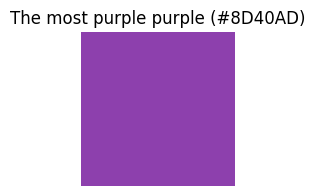

In [9]:
#| label: fig-purple-purple
#| fig-cap: "Average of all purple answers"

purp_rgb = hex_to_rgb(avg_purple)
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.imshow([[purp_rgb]])
ax.set_title("The most purple purple (" + avg_purple + ")")
ax.axis("off")

plt.show()

## Is this really what we want?
We finally have our "perfect" averaging algorithm. Technically, this is as close to calculating the perceptually uniform mean as we can get without optimizing for viewing environment (not practical, as you can imagine), but it may not acurately represent the average response. For example, imagine if someone labeled a dark yellow color as purple: this would skew the average. 

We can consider the case where there are three groups of responses: A very bright pink-ish color, a dark grey-ish purple, and a small subset with a dark yellow color. It would be interesting to see the composition of the groups that form; and, as for our primarly goal, we can try to choose the group with the largest number of entries and average only those. That brings us to clustering.

# Clustering
In order to find groups of colors, we can employ a clustering algorithm. There are many, each with their own strengths and tradeoffs. I'll choose the KMeans algorithm to start since it's relatively simple.

## KMeans
For the KMeans algorithm, we need to choose a number of clusters. Using the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)), we can see that 5 groups fits well.

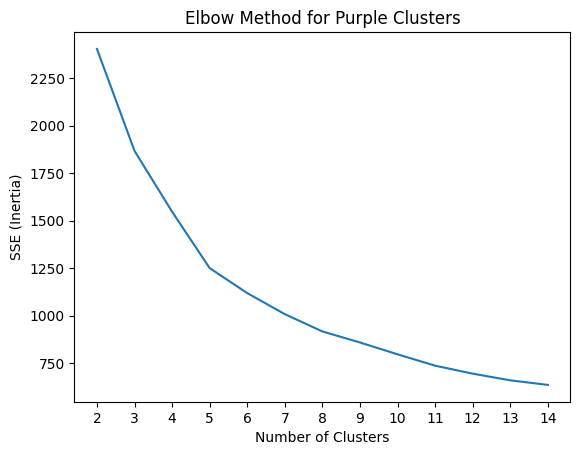

In [10]:
purple_rank = 1
purple_hex_arr = get_hex_series_for_rank(1)

# Get data in the shape (n_entries, 3) in Oklab space
rgb_series = purple_hex_arr.apply(hex_to_rgb).reset_index(drop=True)
lab_series = rgb_series.apply(rgb_to_oklab)

ms_data = np.stack(lab_series.to_numpy())

# Elbow method
possible_clusts = range(2, 15)
inertia = []
for rank in possible_clusts:
    kmeans = KMeans(n_clusters=rank, random_state=42)
    kmeans.fit(ms_data)
    inertia.append(kmeans.inertia_)

plt.plot(possible_clusts, inertia)

plt.xticks(possible_clusts)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Purple Clusters")
plt.show()

In [11]:
# Do the cluster!
purp_n_groups = 5
kmeans = KMeans(n_clusters=purp_n_groups, random_state=42)
purp_labels = kmeans.fit_predict(ms_data)

To visualize the groups, we can use a 3D plot for each cluster.

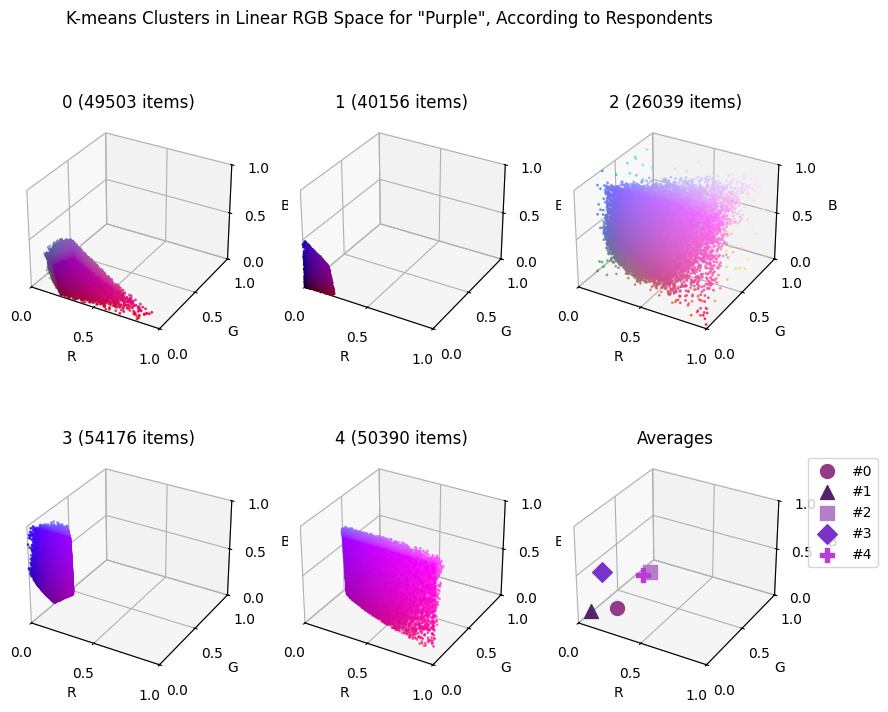

In [12]:
#| label: fig-purple-clusters
#| fig-cap: "Purple Clusters in Linear RGB Space and Their Averages"

fig = plt.figure(figsize=(10, 8))
markers = ['o', '^', 's', 'D', 'P', 'x', '*'] # Different markers for groups

n_axes = purp_n_groups + 1
n_cols = max(math.ceil(n_axes / 2), 1)
n_rows = math.ceil(n_axes / n_cols)

avg_colors = []

for rank in range(0, purp_n_groups):
    ax = fig.add_subplot(n_rows, n_cols, rank + 1, projection='3d')

    # Scatter
    group_colors = rgb_series[purp_labels == rank]
    rgb_array = np.array(group_colors.apply(rgb_remove_gamma).tolist()) / 255
    hex_array = np.array(group_colors.apply(rgb_to_hex).tolist(), dtype=str)

    ax.scatter(rgb_array[:,0], rgb_array[:,1], rgb_array[:,2], c=hex_array, s=1)
    ax.set(xlim=(0,1), ylim=(0,1), zlim=(0,1),
           xticks=[0, 0.5, 1], yticks=[0, 0.5, 1], zticks=[0, 0.5, 1],
           xlabel='R', ylabel='G', zlabel='B',
           title=f'{rank} ({group_colors.size} items)')

    # Average color
    avg_color = find_average_color(group_colors.apply(rgb_to_hex))
    avg_colors.append(avg_color)

# Plot the average colors
ax_2 = fig.add_subplot(n_rows, n_cols, n_axes, projection='3d')

for rank, color_hex in enumerate(avg_colors):
    linear = rgb_remove_gamma(hex_to_rgb(color_hex)) / 255
    ax_2.scatter(linear[0], linear[1], linear[2], c=color_hex, s=100, marker=markers[rank], label=f'#{rank}')

ax_2.set(xlim=(0,1), ylim=(0,1), zlim=(0,1),
       xticks=[0, 0.5, 1], yticks=[0, 0.5, 1], zticks=[0, 0.5, 1],
       xlabel='R', ylabel='G', zlabel='B', title=f'Averages')
ax_2.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.suptitle("K-means Clusters in Linear RGB Space for \"Purple\", According to Respondents")
plt.show()

From the figure (@fig-purple-clusters) it's clear that our intuition about distinct groups checks out. The average for each group is distinct:
- Group 0 has a large range along the red axis, and a bit in the blue axis. It results in a slightly more red-ish purple.
- Group 1 is a dark purple, since the points are all huddled together around the origin.
- Group 2 has the widest range of values and the most outliers (there are points in every corner), but also the least amount of total elements
- Group 3 has the most elements and results in a very blue-ish purple
- Group 4 had a large range across the red axis but also ranges very high into the blue axis, and results in a fairly bright purple.

## Mean-shift clustering
Ideally, I won't have to choose a number of clusters manually for each color. There are methods to algorithmically find a number of clusters for K-means, but it would be better to use a method that doesn't require us to specify the number of clusters at all. Mean-shift is a "mode-seeking" algorithm, so if the data is multi-modal, we should get a distinct cluster for each (but we could end up with just one, if there is only one mode).

In [17]:
# Find bandwidth
purp_bandwidth = estimate_bandwidth(ms_data, n_samples=(ms_data.size // 20))
print("bandwidth =", purp_bandwidth)

# Fit data
purp_mean_shift = MeanShift(bandwidth=purp_bandwidth, bin_seeding=True)
purp_mean_shift.fit_predict(ms_data)

purp_labels = purp_mean_shift.labels_
purp_centers = purp_mean_shift.cluster_centers_
purp_n_groups = len(np.unique(purp_labels))

print(f"Number of estimated clusters: {purp_n_groups}")

bandwidth = 0.13097356905552626
Number of estimated clusters: 2


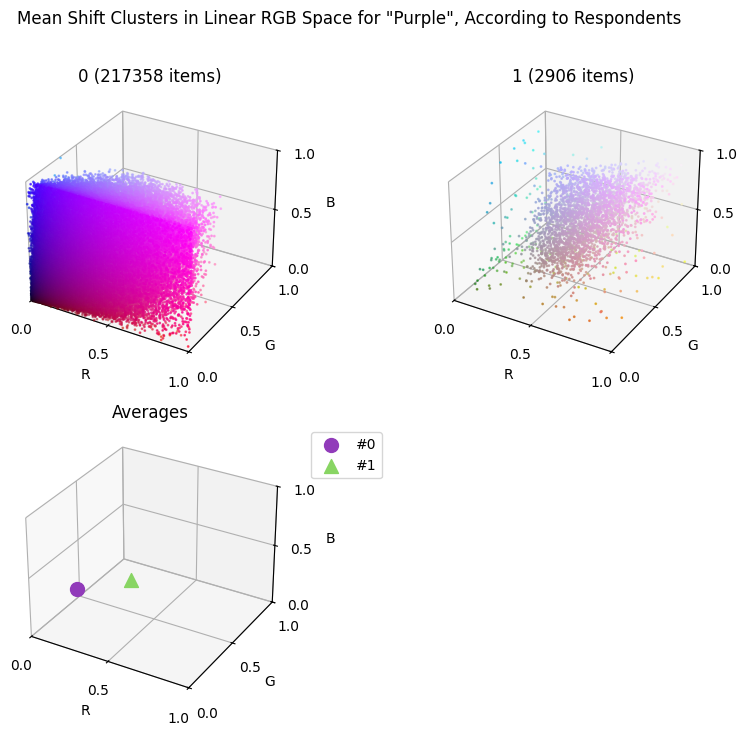

In [18]:
fig = plt.figure(figsize=(10, 8))
markers = ['o', '^', 's', 'D', 'P', 'x', '*'] # Different markers for groups

n_axes = purp_n_groups + 1
n_cols = max(math.ceil(n_axes / 2), 1)
n_rows = math.ceil(n_axes / n_cols)

# Axis for group centers
avg_ax = fig.add_subplot(n_rows, n_cols, n_axes, projection='3d')
avg_ax.set(xlim=(0,1), ylim=(0,1), zlim=(0,1),
       xticks=[0, 0.5, 1], yticks=[0, 0.5, 1], zticks=[0, 0.5, 1],
       xlabel='R', ylabel='G', zlabel='B', title=f'Averages')

# Plot each group in separate axis
for rank in range(0, purp_n_groups):
    ax = fig.add_subplot(n_rows, n_cols, rank + 1, projection='3d')

    # Scatter
    group_colors = rgb_series[purp_labels == rank]
    rgb_array = np.array(group_colors.apply(rgb_remove_gamma).tolist()) / 255
    hex_array = np.array(group_colors.apply(rgb_to_hex).tolist(), dtype=str)

    ax.scatter(rgb_array[:,0], rgb_array[:,1], rgb_array[:,2], c=hex_array, s=1)
    ax.set(xlim=(0,1), ylim=(0,1), zlim=(0,1),
           xticks=[0, 0.5, 1], yticks=[0, 0.5, 1], zticks=[0, 0.5, 1],
           xlabel='R', ylabel='G', zlabel='B',
           title=f'{rank} ({group_colors.size} items)')

    # Average color
    center_rgb = oklab_to_rgb(purp_centers[rank])
    center_lin = rgb_remove_gamma(center_rgb) / 255
    center_hex = rgb_to_hex(center_rgb)

    avg_ax.scatter(center_lin[0], center_lin[1], center_lin[2], c=center_hex, s=100, marker=markers[rank], label=f'#{rank}')

avg_ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.suptitle("Mean Shift Clusters in Linear RGB Space for \"Purple\", According to Respondents")
plt.show()

This result is very different from before. I would only call Group 0 "purple"; Group 1 has much more discordant colors with the average what I would call "lime" or "green", as well as much less data points. If we choose the group with the largest number of entries (0), I'd say that is a better representation of the average value, since we've essentially discarded the outliers. Let's try our method with the top 5 colors, and see the average for each.

In [68]:
def get_mean_shift(hex_values: "pd.Series[str]", sample_divisor: int, max_sample_size: int = 20000) -> dict:
    # Transform data
    rgb_values = hex_values.apply(hex_to_rgb)
    lab_values = rgb_values.apply(rgb_to_oklab)

    data_arr = np.stack(lab_values.to_numpy())

    # Calculate bandwidth (will take a while...)
    sample_size = min(max_sample_size, len(data_arr) // sample_divisor)
    data_bandwidth = estimate_bandwidth(data_arr, n_samples=sample_size)

    # Mean shift
    mean_shift = MeanShift(bandwidth=data_bandwidth, bin_seeding=True)
    mean_shift.fit_predict(data_arr)

    labels = mean_shift.labels_
    centers = mean_shift.cluster_centers_
    group_count =  len(np.unique(labels))

    return {
        'bandwidth': data_bandwidth,
        'centers': centers,
        'n_groups': group_count,
        'data': pd.DataFrame({
            'hex': hex_values.to_numpy(),
            'rgb': rgb_values.to_numpy(),
            'lab': lab_values.to_numpy(),
            'group': labels
        })
    }

n_colors_to_check = 5
mean_shift_data = []

for rank in range(1, n_colors_to_check + 1):
    hex_series = get_hex_series_for_rank(rank).reset_index(drop=True)
    mean_shift_data.append(get_mean_shift(hex_series, sample_divisor=20))

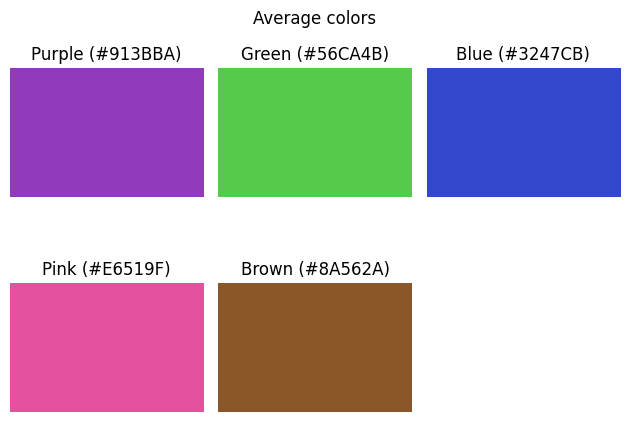

In [69]:
def get_color_name(color_rank: int) -> str:
    name = color_ranks.loc[color_rank]["color"]
    return name.title()

fig = plt.figure()
n_axes = n_colors_to_check + 1
n_cols = max(math.ceil(n_axes / 2), 1)
n_rows = math.ceil(n_axes / n_cols)

for rank, ms_data in enumerate(mean_shift_data, 1):
    color_name = get_color_name(rank)

    # Find the largest group
    largest_groups = ms_data['data']['group'].mode()

    if len(largest_groups) > 1:
        print("There was a tie!") # Theoretically possible to have a tie

    largest_group = largest_groups[0]

    group_center = ms_data['centers'][largest_group] # Lab coordinates
    center_rgb = oklab_to_rgb(group_center)
    center_hex = rgb_to_hex(center_rgb)

    # Plot
    ax = fig.add_subplot(n_rows, n_cols, rank)
    ax.imshow(np.full((2, 3, 3), center_rgb)) # 2x3 array of rgb (3,)
    ax.set_title(f"{color_name} ({center_hex})")
    ax.axis("off")

plt.tight_layout()
plt.suptitle("Average colors")
plt.show()

We can also visualize how many groups each color has:

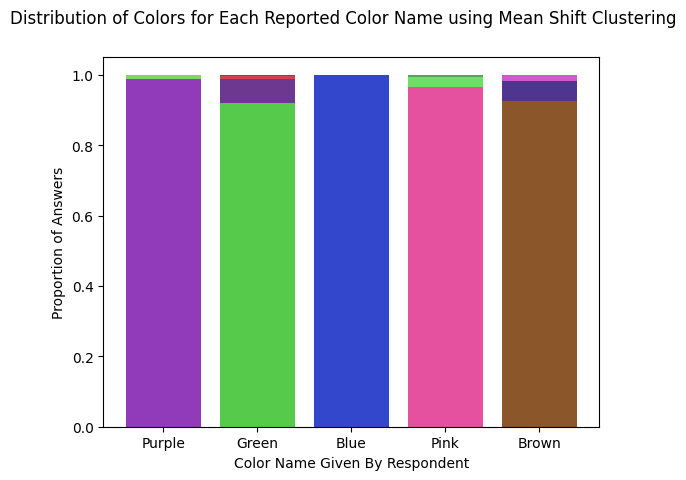

In [87]:
#| label: fig-colors-dist
#| fig-cap: "Distribution of Colors for Each Reported Color Name using Mean Shift Clustering"

fig, ax = plt.subplots()

for rank, ms_data in enumerate(mean_shift_data, 1):
    labels = ms_data['data']['group']
    label_counts = labels.value_counts() / labels.size

    bottom = 0
    for cluster, size in label_counts.items():

        center = ms_data['centers'][cluster] # Oklab
        color = rgb_to_hex(oklab_to_rgb(center))

        ax.bar(rank, size, bottom=bottom, width=0.8, color=color)
        bottom += size

ax.set_xticks(range(1, n_colors_to_check + 1))
ax.set_xticklabels([get_color_name(i) for i in range(1, n_colors_to_check + 1)])
ax.set_ylabel("Proportion of Answers")
ax.set_xlabel("Color Name Given By Respondent")

plt.suptitle("Distribution of Colors for Each Reported Color Name using Mean Shift Clustering")
plt.show()

In the above figure (@fig-colors-dist), we can see that while most people's answers were in the same group, green and brown have outlier groups of about 10%. While it may look like 1/10th of people were shown purple or red and answered "green", remember that mean shift is a mode-seeking algorithm. Imagine a multi-modal graph (distribution with two peaks, one higher than the other). The average color shown as the color of each bar segment is the center of the cluster, and each cluster is a mode, so respondents weren't shown *exactly* that color, but it was closer to that color than the other mode (the largest peak).

# Conclusion
It turns out that working with colors is complicated. Luckily, we got some good visualizations out of it. Of course, your interpretation of the results will depend on a few factors (your eyes, if you're color blind, etc.), but it appears as if the averages were perfectly sensible. We only looked at 5 colors, but if this were to be expanded it should work for any number of colors. The complete dataset is massive, so the subset I'm using only includes the top 5 colors, but the same methods apply for anyone that wants to wait a couple of hours running the mean shift algorithm. I may come back to this project in the future, because I learned a lot and it turned out incredibly interesting!